In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

import zarr
import dask.array as da

from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

from scipy.ndimage import zoom

from pyometiff import OMETIFFReader
import pathlib

# from aicsimageio import AICSImage

from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

import os 
import sys
import math

import xml.etree.ElementTree as ET

In [28]:
class OmeZarrConnector: 
  """
  Connector for ome zarr files
  """
  def __init__(self, path):
    """
    Initialize the connector

    Args:
    path: path to the ome zarr file
    """
    self.path = path # Path to the ome zarr file
    self.metadata = [] # Metadata for the ome zarr file
    self.full_size_x = 0 # Full shape of the image in x direction
    self.full_size_y = 0
    self.zarr_connection = zarr.open(self.path) # Open the zarr file
    self.total_zoom_levels = len(self.zarr_connection[0]) # Total zoom levels in the main image zarr file
    self.dzi_total_zoom_levels = 0 # Total zoom levels in the dzi file
    self.tile_size = 256 # Tile size square
    self.largest_zoom_level_with_full_tile = 0
    self.number_of_channels = 0
    self.color_map = {
      'red': [1, 0, 0],
      'green': [0, 1, 0],
      'blue': [0, 0, 1],
      'yellow': [1, 1, 0],
      'magenta': [1, 0, 1],
      'cyan': [0, 1, 1],
      'white': [1, 1, 1]
    }
  
    self.get_metadata()
    self.calculate_largest_zoom_level_with_full_tile()
    self.calculate_dzi_total_zoom_levels()
    self.find_number_of_channels()

  def find_number_of_channels(self) -> None:
    """
    Find the number of channels in the ome zarr file
    """
    da_zarr = da.from_zarr(self.zarr_connection[0][0])
    self.number_of_channels = da_zarr.shape[1]

  def calculate_dzi_total_zoom_levels(self) -> None:
    """
    Calculate the total number of zoom levels for DZI pyramid,
    continuing until the image is scaled down to less than 1 pixel
    in either dimension.
    """
    # Ensure full_size_x and full_size_y are initialized
    if self.full_size_x <= 0 or self.full_size_y <= 0:
        raise ValueError("Full size dimensions must be positive numbers")

    # Get the largest dimension
    max_dimension = max(self.full_size_x, self.full_size_y)

    # Calculate the number of times we need to divide by 2 to get below 1
    self.dzi_total_zoom_levels = math.ceil(math.log2(max_dimension))
  
  def calculate_largest_zoom_level_with_full_tile(self) -> None:
    # Calculate how many times we can halve x and y before they become smaller than tile size
    max_zoom_x = math.floor(math.log2(self.full_size_x / self.tile_size))
    max_zoom_y = math.floor(math.log2(self.full_size_y / self.tile_size))
    
    # Return the smaller of the two values
    self.largest_zoom_level_with_full_tile = min(max_zoom_x, max_zoom_y)

  def return_metadata(self) -> dict:
    """
    Return metadata for the ome zarr file
    """
    return self.metadata

  def get_metadata(self) -> None:
    """
    Get metadata for the ome zarr file
    """
    tree = ET.parse(os.path.join(self.path, 'OME', 'METADATA.ome.xml'))
    root = tree.getroot()

    namespace = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
    self.metadata = []
    # Get image metadata
    for image in root.findall('ome:Image', namespace):
      image_id = image.get('ID')
      image_name = image.get('Name')

      # Get image details
      pixel_info = []
      pixels = image.find('ome:Pixels', namespace)
      if pixels is not None:
        size_x = pixels.get('SizeX')
        size_y = pixels.get('SizeY')
        size_c = pixels.get('SizeC')
        physical_size_x = pixels.get('PhysicalSizeX')
        physical_size_x_unit = pixels.get('PhysicalSizeXUnit')
        physical_size_y = pixels.get('PhysicalSizeY')
        physical_size_y_unit = pixels.get('PhysicalSizeYUnit')
        pixel_info.append({
            'size_x': size_x,
            'size_y': size_y,
            'size_c': size_c,
            'physical_size_x': physical_size_x,
            'physical_size_x_unit': physical_size_x_unit,
            'physical_size_y': physical_size_y,
            'physical_size_y_unit': physical_size_y_unit
            })
        
      # Get channel information
      channel_info = []
      for channel in image.findall('.//ome:Channel', namespace):
          channel_id = channel.get('ID')
          channel_name = channel.get('Name')
          channel_info.append({
              'channel_id': channel_id,
              'channel_name': channel_name
              })
          # print(f"  Channel: {channel_id}, Name: {channel_name}")
        
      self.metadata.append({
          'image_id': image_id,
          'image_name': image_name,
          'pixel_info': pixel_info,
          'channel_info': channel_info
          })
    
    self.full_size_x = int(self.metadata[0]['pixel_info'][0]['size_x']) # assuming first image is the main image
    self.full_size_y = int(self.metadata[0]['pixel_info'][0]['size_y']) # assuming first image is the main image
  
  def return_color_map(self) -> dict: 
    """
    Return the color map
    """
    return self.color_map
  
  def generate_dzi(self, image_id) -> str:
    """
    Generate dzi text for the ome zarr file

    Args:
      image_id: image id (the sequential number) for which dzi file needs to be generated

    """
    # Get image size
    size_x = self.metadata[image_id]['pixel_info'][0]['size_x']
    size_y = self.metadata[image_id]['pixel_info'][0]['size_y']
    # Generate dzi

    dzi = '<?xml version="1.0" encoding="UTF-8"?>\n'
    dzi += f'<Image TileSize="256" Overlap="0" Format="png" xmlns="http://schemas.microsoft.com/deepzoom/2008">\n'
    dzi += f'  <Size Width="{size_x}" Height="{size_y}"/>\n'
    dzi += '</Image>\n'

    return dzi
  
  def get_tile_image(self, image_id, zoom_level, channel, tile_x, tile_y) -> np.array:
    """
    Get a tile from the ome zarr file, with support for DZI zoom levels

    Args:
      image_id: image id (the sequential number) for which tile needs to be extracted
      zoom_level: zoom level (DZI format, where higher numbers mean more zoomed out)
      channel: channel to be extracted
      tile_x: x coordinate of the tile
      tile_y: y coordinate of the tile
    """
    root = self.zarr_connection[image_id]
    
    # Determine the zarr zoom level
    zarr_zoom_level = min(zoom_level, self.largest_zoom_level_with_full_tile)
    da_zarr = da.from_zarr(root[zarr_zoom_level])

    full_width = da_zarr.shape[4]
    full_height = da_zarr.shape[3]
    
    # Calculate the region of the image to extract
    tile_size = self.tile_size  # Assuming square tiles
    start_x = tile_x * tile_size 
    start_y = tile_y * tile_size
    end_x = min(start_x + tile_size, full_width)
    end_y = min(start_y + tile_size, full_height)
    
    # Extract the region from the Dask array
    if zoom_level < self.largest_zoom_level_with_full_tile:
      region = da_zarr[0, channel, 0, start_y:end_y, start_x:end_x].compute()

    # If we're at a deeper zoom level than the zarr file provides, we need to scale
    else:
      scale_factor = 2 ** (zoom_level - self.largest_zoom_level_with_full_tile)
      level_width = full_width // scale_factor
      level_height = full_height // scale_factor
      
      # Calculate the region of the image to extract
      start_x = tile_x * self.tile_size
      start_y = tile_y * self.tile_size
      end_x = min(start_x + self.tile_size, level_width)
      end_y = min(start_y + self.tile_size, level_height)
      
      # Calculate the region in the original image coordinates
      orig_start_x = start_x * scale_factor
      orig_start_y = start_y * scale_factor
      orig_end_x = end_x * scale_factor
      orig_end_y = end_y * scale_factor
      
      # Extract the region from the Dask array
      region = da_zarr[0, channel, 0, orig_start_y:orig_end_y, orig_start_x:orig_end_x].compute()

      new_width = end_x - start_x
      new_height = end_y - start_y

      try:
        region = cv2.resize(region, (new_width, new_height), interpolation=cv2.INTER_AREA)
      except: 
        region = np.array([1])

    return region
  
  def get_combined_image(self, 
                         image_id = 0, 
                         dzi_zoom_level = 1, 
                         channels = [0], 
                         intensities=[1], 
                         colors=['blue'], 
                         is_rgb = False, 
                         tile_x = 0, 
                         tile_y = 0) -> np.array:
    """
    Get a combined image from the ome zarr file

    Args:
      image_id: image id (the sequential number) for which tile needs to be extracted
      dzi_zoom_level: zoom level
      channels: list of channels to be extracted
      intensities: list of intensities for each channel
      colors: list of colors for each channel
      tile_x: x coordinate of the tile
      tile_y: y coordinate of the tile
    """

    # Get the zoom level for the zarr file
    zoom_level = self.dzi_total_zoom_levels - dzi_zoom_level - 2

    merged_image = None #np.zeros((self.tile_size, self.tile_size, 3), dtype=np.uint8)
    
    if not is_rgb:
      for channel, intensity, color in zip(channels, intensities, colors):
        color_rgb = self.color_map[color]
        image = self.get_tile_image(image_id, zoom_level, channel, tile_x, tile_y)
        enhanced_image = cv2.convertScaleAbs(image, alpha=intensity)
        colored_image = cv2.merge([enhanced_image * color_rgb[i] for i in range(3)])
        if merged_image is None:
          merged_image = colored_image
        merged_image = cv2.add(merged_image, colored_image)
    else:
      for channel in channels:
        image = self.get_tile_image(image_id, zoom_level, channel, tile_x, tile_y)
        if merged_image is None:
          merged_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        merged_image[:, :, channel] = image
    
    return merged_image

In [29]:
# test_ome = OmeZarrConnector('/Users/vanijzen/Desktop/example-raw.zarr')
test_ome = OmeZarrConnector('/Users/vanijzen/Desktop/public/TMA1.zarr')


# test_ome.generate_dzi(0)

test_ome.return_metadata()

# plt.imshow(test_ome.get_tile_image(0, 0, 0, 0, 0))

# plt.imshow(test_ome.get_combined_image(0, 12, [0, 1, 2], [1, 1, 1], ['red', 'green', 'blue'], 1, 1))
# plt.imshow(test_ome.get_combined_image(0, 9, [0, 1, 2], [1, 1, 1], ['red', 'green', 'blue'], True, 0, 0))


[{'image_id': 'Image:0',
  'image_name': '',
  'pixel_info': [{'size_x': '75696',
    'size_y': '58261',
    'size_c': '3',
    'physical_size_x': '0.2524',
    'physical_size_x_unit': 'µm',
    'physical_size_y': '0.2524',
    'physical_size_y_unit': 'µm'}],
  'channel_info': [{'channel_id': 'Channel:0:0', 'channel_name': None},
   {'channel_id': 'Channel:0:1', 'channel_name': None},
   {'channel_id': 'Channel:0:2', 'channel_name': None}]},
 {'image_id': 'Image:1',
  'image_name': 'label image',
  'pixel_info': [{'size_x': '729',
    'size_y': '713',
    'size_c': '3',
    'physical_size_x': None,
    'physical_size_x_unit': None,
    'physical_size_y': None,
    'physical_size_y_unit': None}],
  'channel_info': [{'channel_id': 'Channel:1:0', 'channel_name': None},
   {'channel_id': 'Channel:1:1', 'channel_name': None},
   {'channel_id': 'Channel:1:2', 'channel_name': None}]},
 {'image_id': 'Image:2',
  'image_name': 'macro image',
  'pixel_info': [{'size_x': '1600',
    'size_y': '61

In [329]:
test_ome.return_metadata()

[{'image_id': 'Image:0',
  'image_name': '',
  'pixel_info': [{'size_x': '75696',
    'size_y': '58261',
    'size_c': '3',
    'physical_size_x': '0.2524',
    'physical_size_x_unit': 'µm',
    'physical_size_y': '0.2524',
    'physical_size_y_unit': 'µm'}]},
 {'image_id': 'Image:1',
  'image_name': 'label image',
  'pixel_info': [{'size_x': '729',
    'size_y': '713',
    'size_c': '3',
    'physical_size_x': None,
    'physical_size_x_unit': None,
    'physical_size_y': None,
    'physical_size_y_unit': None}]},
 {'image_id': 'Image:2',
  'image_name': 'macro image',
  'pixel_info': [{'size_x': '1600',
    'size_y': '610',
    'size_c': '3',
    'physical_size_x': None,
    'physical_size_x_unit': None,
    'physical_size_y': None,
    'physical_size_y_unit': None}]}]

In [321]:
# zarr_connection = zarr.open('/Users/vanijzen/Desktop/example-raw.zarr') # Open the zarr file
zarr_connection = zarr.open('/Users/vanijzen/Desktop/TMA1.zarr') # Open the zarr file

da_zarr = da.from_zarr(zarr_connection[0][2])

In [322]:
da_zarr.shape

(1, 3, 1, 14565, 18924)

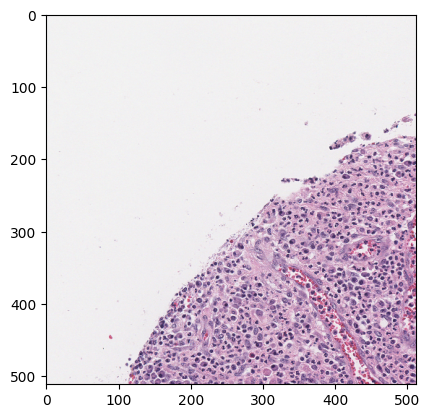

In [325]:
rgb_image = da_zarr[0, 0:3, 0, 512:1024, 512:1024].compute()
rgb_image = np.transpose(rgb_image, (1, 2, 0))

plt.imshow(rgb_image)

In [282]:
len(zarr_connection[0])

10

In [24]:
tree = ET.parse('/Users/vanijzen/Desktop/public/example-raw.zarr/OME/METADATA.ome.xml')
root = tree.getroot()


In [25]:
for image in root.findall('ome:Image', namespace):
  print(image)

<Element '{http://www.openmicroscopy.org/Schemas/OME/2016-06}Image' at 0x1ad190310>
<Element '{http://www.openmicroscopy.org/Schemas/OME/2016-06}Image' at 0x1ad0ac950>
<Element '{http://www.openmicroscopy.org/Schemas/OME/2016-06}Image' at 0x1ad0af510>
<Element '{http://www.openmicroscopy.org/Schemas/OME/2016-06}Image' at 0x1ad290f90>


In [26]:
# Find the namespace
namespace = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}

images = []

# Get image information
for image in root.findall('ome:Image', namespace):
    image_id = image.get('ID')
    image_name = image.get('Name')
    print(f"Image ID: {image_id}, Name: {image_name}")

    pixel_info = []

    # Get pixel information
    pixels = image.find('ome:Pixels', namespace)
    if pixels is not None:
        size_x = pixels.get('SizeX')
        size_y = pixels.get('SizeY')
        size_c = pixels.get('SizeC')
        physical_size_x = pixels.get('PhysicalSizeX')
        physical_size_x_unit = pixels.get('PhysicalSizeXUnit')
        physical_size_y = pixels.get('PhysicalSizeY')
        physical_size_y_unit = pixels.get('PhysicalSizeYUnit')
        print(f"  Dimensions: {size_x}x{size_y}, Channels: {size_c}")
        print(f"  Physical Size X: {physical_size_x} {physical_size_x_unit}")
        print(f"  Physical Size Y: {physical_size_y} {physical_size_y_unit}")

        pixel_info.append({
            'size_x': size_x,
            'size_y': size_y,
            'size_c': size_c,
            'physical_size_x': physical_size_x,
            'physical_size_x_unit': physical_size_x_unit,
            'physical_size_y': physical_size_y,
            'physical_size_y_unit': physical_size_y_unit
            })
        
        images.append({
            'image_id': image_id,
            'image_name': image_name,
            'pixel_info': pixel_info
        })

    # Get channel information
    for channel in image.findall('.//ome:Channel', namespace):
        channel_id = channel.get('ID')
        channel_name = channel.get('Name')
        print(f"  Channel: {channel_id}, Name: {channel_name}")

# Get instrument information
instrument = root.find('ome:Instrument', namespace)
if instrument is not None:
    objective = instrument.find('ome:Objective', namespace)
    if objective is not None:
        model = objective.get('Model')
        magnification = objective.get('NominalMagnification')
        print(f"Objective: {model}, Magnification: {magnification}x")

# Get annotations
for annotation in root.findall('.//ome:OriginalMetadata', namespace):
    key = annotation.find('ome:Key', namespace)
    value = annotation.find('ome:Value', namespace)
    if key is not None and value is not None:
        print(f"Metadata: {key.text} = {value.text}")

Image ID: Image:0, Name: resolution #1
  Dimensions: 24960x34560, Channels: 5
  Physical Size X: 0.49799447890790055 µm
  Physical Size Y: 0.49799447890790055 µm
  Channel: Channel:0:0, Name: DAPI
  Channel: Channel:0:1, Name: FITC
  Channel: Channel:0:2, Name: CY3
  Channel: Channel:0:3, Name: Texas Red
  Channel: Channel:0:4, Name: CY5
Image ID: Image:1, Name: thumbnail
  Dimensions: 195x270, Channels: 3
  Physical Size X: 63.74357968190302 µm
  Physical Size Y: 63.74357968190302 µm
  Channel: Channel:1:0, Name: None
  Channel: Channel:1:1, Name: None
  Channel: Channel:1:2, Name: None
Image ID: Image:2, Name: Overview
  Dimensions: 2090x4036, Channels: 3
  Physical Size X: 13.875598091137501 µm
  Physical Size Y: 13.875598091137501 µm
  Channel: Channel:2:0, Name: None
  Channel: Channel:2:1, Name: None
  Channel: Channel:2:2, Name: None
Image ID: Image:3, Name: Label
  Dimensions: 522x450, Channels: 3
  Physical Size X: 55.502392364550005 µm
  Physical Size Y: 55.502392364550005 µm

In [135]:
file_path = "/Users/vanijzen/Desktop/example-raw.zarr"

store = parse_url(file_path, mode="r").store

reader = Reader(parse_url(file_path))

In [138]:
store.data

AttributeError: 'FSStore' object has no attribute 'data'

In [134]:
for readers in reader():
    print(readers)

In [126]:
# nodes = list(reader())

In [123]:
reader.data

AttributeError: 'Reader' object has no attribute 'data'

In [105]:
img_fpath = pathlib.Path('/Users/vanijzen/Desktop/example.ome.tiff')
reader = OMETIFFReader(fpath=img_fpath)

In [106]:
img_array, metadata, xml_metadata = reader.read()

key not found 'NoneType' object has no attribute 'iter'


In [110]:
metadata

{'Directory': '/Users/vanijzen/Desktop',
 'Filename': 'example.ome.tiff',
 'Extension': 'ome.tiff',
 'ImageType': 'ometiff',
 'TotalSeries': 4,
 'SizeX': 24960,
 'SizeY': 34560,
 'SizeZ': 1,
 'SizeC': 5,
 'SizeT': 1,
 'SizeS': 1,
 'SizeB': 1,
 'SizeM': 1,
 'PhysicalSizeX': 0.49799447890790055,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.49799447890790055,
 'PhysicalSizeYUnit': 'µm',
 'Sizes BF': [4, 1, 1, 5, 34560, 24960],
 'DimOrder BF': 'XYZCT',
 'DimOrder BF Array': 'TCZYX',
 'ObjMag': '10.0',
 'ObjID': 'Objective:0:0',
 'DetectorID': 'Detector:0:0',
 'InstrumentID': 'Instrument:0',
 'Channels': {'DAPI': {'Name': 'DAPI',
   'ID': 'Channel:0:0',
   'SamplesPerPixel': 1,
   'Color': '65535'},
  'FITC': {'Name': 'FITC',
   'ID': 'Channel:0:1',
   'SamplesPerPixel': 1,
   'Color': '16711935'},
  'CY3': {'Name': 'CY3',
   'ID': 'Channel:0:2',
   'SamplesPerPixel': 1,
   'Color': '-65281'},
  'Texas Red': {'Name': 'Texas Red',
   'ID': 'Channel:0:3',
   'SamplesPerPixel': 1,
   'Color

In [108]:
img_array.shape

(5, 34560, 24960)

In [25]:
# img = cv2.imread('/Volumes/external/tissueviewer/example-raw/0/0/0/0/0/0/0',cv2.IMREAD_UNCHANGED)

In [22]:
root = zarr.open('/Volumes/external/tissueviewer/example-raw.zarr/')[0][0]

KeyError: '.zgroup'

In [35]:
root = zarr.open('/Users/vanijzen/Desktop/example-raw.zarr')[0][3]

# first is the pixel data
# second is the pyramid level, lower is higher resolution

da_zarr = da.from_zarr(root)

# da_zarr[0,0,0].compute().shape

da_zarr.shape

(1, 5, 1, 4320, 3120)

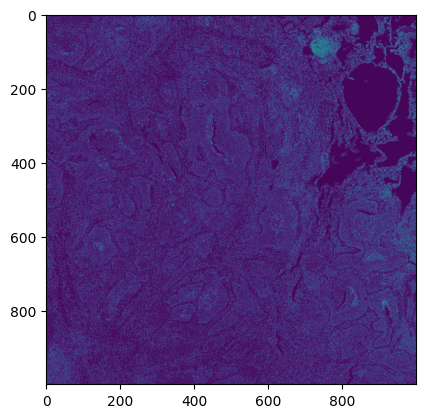

In [40]:
plt.imshow(da_zarr[0, 0, 0, 1000:2000, 1000:2000].compute())

In [49]:
original_shape = da_zarr[0, 0, 0].shape
original_height, original_width = original_shape

In [65]:
new_width = 256
new_height = int(original_height * (new_width / original_width))
scale_factor = new_height / original_height

In [66]:
print(scale_factor)

0.010243055555555556


In [67]:
def resize_image(img, scale):
    return zoom(img, scale)

In [81]:
scaled_image = da.map_overlap(resize_image, da_zarr[0, 1, 0], scale=scale_factor, 
                              depth=1, boundary='reflect')

In [82]:
scaled_image.compute().shape

(303, 218)

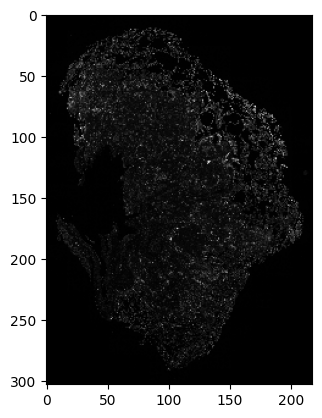

In [83]:
plt.imshow(scaled_image.compute(), cmap='gray')

In [84]:
def get_dzi_tile(da_zarr, tile_x, tile_y, level):
    """
    Generate a DZI tile from a Dask array.
    
    :param da_zarr: Dask array containing the image data
    :param tile_x: X coordinate of the tile
    :param tile_y: Y coordinate of the tile
    :param level: Zoom level (0 is maximum zoom, higher numbers are zoomed out)
    :return: A 256x256 numpy array representing the tile
    """
    # Get the shape of the full resolution image
    full_height, full_width = da_zarr[0, 0, 0].shape
    
    # Calculate the dimensions at the current zoom level
    scale_factor = 2 ** level
    level_width = full_width // scale_factor
    level_height = full_height // scale_factor
    
    # Calculate the region of the image to extract
    start_x = tile_x * 256
    start_y = tile_y * 256
    end_x = min(start_x + 256, level_width)
    end_y = min(start_y + 256, level_height)
    
    # Calculate the region in the original image coordinates
    orig_start_x = start_x * scale_factor
    orig_start_y = start_y * scale_factor
    orig_end_x = end_x * scale_factor
    orig_end_y = end_y * scale_factor
    
    # Extract the region from the Dask array
    region = da_zarr[0, 0, 0, orig_start_y:orig_end_y, orig_start_x:orig_end_x]
    
    # Compute the region and resize it
    computed_region = region.compute()
    if level > 0:
        computed_region = zoom(computed_region, 1/scale_factor)
    
    # Create a 256x256 tile and fill it with the computed region
    tile = np.zeros((256, 256), dtype=computed_region.dtype)
    tile_region_height, tile_region_width = computed_region.shape
    tile[:tile_region_height, :tile_region_width] = computed_region
    
    return tile

In [104]:
def get_dzi_tile(da_zarr, tile_x, tile_y, level):
    """
    Generate a DZI tile from a Dask array using efficient coarsening.
    
    :param da_zarr: Dask array containing the image data
    :param tile_x: X coordinate of the tile
    :param tile_y: Y coordinate of the tile
    :param level: Zoom level (0 is maximum zoom, higher numbers are zoomed out)
    :return: A 256x256 numpy array representing the tile
    """
    # Get the shape of the full resolution image
    full_height, full_width = da_zarr[0, 0, 0].shape
    
    # Calculate the dimensions at the current zoom level
    scale_factor = 2 ** level
    level_width = full_width // scale_factor
    level_height = full_height // scale_factor
    
    # Calculate the region of the image to extract
    start_x = tile_x * 256 * scale_factor
    start_y = tile_y * 256 * scale_factor
    end_x = min(start_x + 256 * scale_factor, full_width)
    end_y = min(start_y + 256 * scale_factor, full_height)
    
    # Extract the region from the Dask array
    region = da_zarr[0, 0, 0, start_y:end_y, start_x:end_x]
    
    # Apply coarsening if level > 0
    if level > 0:
        region = da.coarsen(np.mean, region, {0: scale_factor, 1: scale_factor})
    
    # Compute the region
    computed_region = region.compute()
    
    # Ensure the computed region is exactly 256x256
    tile = np.zeros((256, 256), dtype=computed_region.dtype)
    tile_region_height, tile_region_width = computed_region.shape
    tile[:min(256, tile_region_height), :min(256, tile_region_width)] = computed_region[:256, :256]
    
    return tile

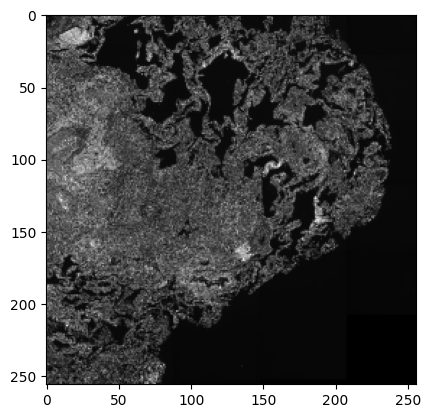

In [117]:
tile = get_dzi_tile(da_zarr, tile_x=2, tile_y=2, level=5)
plt.imshow(tile, cmap='gray')

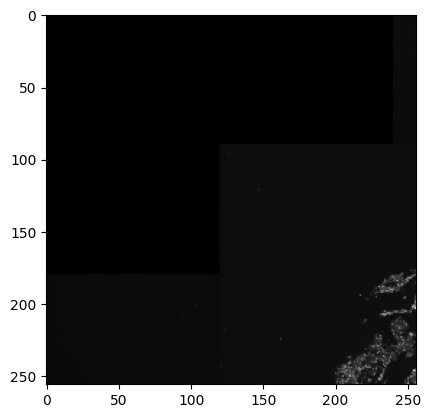

In [110]:
plt.imshow(tile, cmap='gray')

In [115]:
dask_array = da.from_zarr(root)

In [95]:
reader = Reader('/Volumes/external/tissueviewer/example-raw/')

AttributeError: 'str' object has no attribute 'exists'

In [47]:
[key for key in root.keys() if key.isdigit()]

['0', '1', '2', '3']

In [96]:
at_level = root[0][0]

In [106]:
at_level[0,1,0][100:200,100:200]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [84]:
at_level.chunks

AttributeError: 'numpy.ndarray' object has no attribute 'chunks'

In [87]:
np.array(at_level).shape

(1, 34560, 24960)

In [43]:
tiles.shape

AttributeError: 

TypeError: Image data of dtype object cannot be converted to float

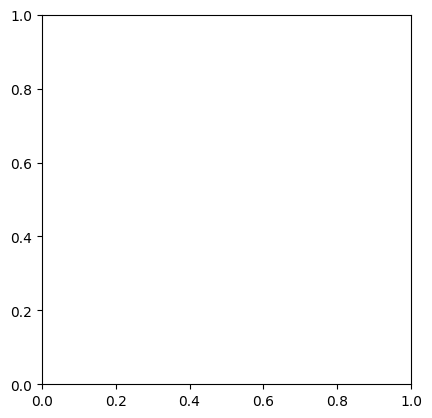

In [19]:
plt.imshow(img)

In [17]:
np.array(img).shape

()